
# Spectral Unmixing of STEM Images

by Rama Vasudevan

Center for Nanophase Materials Sciences

Oak Ridge National Laboratory, Oak Ridge TN 37831, USA

In this notebook we load some imaging data, and then use spectral unmixing tools to separate distinct phases

Read more in our paper:

**Vasudevan, Rama K., et al. "Phases and interfaces from real space atomically resolved data: physics-based deep data image analysis." Nano letters 16.9 (2016): 5574-5581.**



In [1]:
%%shell
#This is the data
gdown https://drive.google.com/uc?id=1lpsLXNa3fiKRmnK7ep_SB8aR3paZ8b29

#Unzip
unzip fft_and_image.zip

Downloading...
From: https://drive.google.com/uc?id=1lpsLXNa3fiKRmnK7ep_SB8aR3paZ8b29
To: /content/fft_and_image.zip
6.57MB [00:00, 15.9MB/s]
Archive:  fft_and_image.zip
  inflating: SuperImage.npy          
  inflating: fft_utils.py            
   creating: __MACOSX/
  inflating: __MACOSX/._fft_utils.py  


In [2]:
#Load the necessary data and packages
!pip install pysptools pyUSID

#Import numpy and matplotlib for numerical computation and plotting
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

#The fft_utils contains the Sliding Window Module
from fft_utils import *


     |████████████████████████████████| 8.1MB 4.1MB/s 
     |████████████████████████████████| 174kB 34.0MB/s 
     |████████████████████████████████| 81kB 8.4MB/s 
     |████████████████████████████████| 788kB 49.1MB/s 
     |████████████████████████████████| 481kB 42.0MB/s 
     |████████████████████████████████| 358kB 39.8MB/s 
  Created wheel for pysptools: filename=pysptools-0.15.0-cp36-none-any.whl size=8133752 sha256=0b4ed802e59e89414c0e15a091c0a69560b3634b5cb87c63155bec04880af5c0
  Stored in directory: /root/.cache/pip/wheels/bf/60/be/a6719d91bfa59135201feb034c7069e4146aa576fc0dc9e624
  Created wheel for cytoolz: filename=cytoolz-0.11.0-cp36-cp36m-linux_x86_64.whl size=1225549 sha256=65942faf2d4a0dfb3c79f14d84e29eb110b2046096523b23144a7d133160bbff
  Stored in directory: /root/.cache/pip/wheels/a1/32/3c/9c9926b510647cacdde744b2c7acdf1ccd5896fbb7f8d5df0c
Successfully built pysptools cytoolz
ERROR: jupyter-console 5.2.0 has requirement prompt-toolkit<2.0.0,>=1.0.0, but you'll have

/usr/local/lib/python3.6/dist-packages/pyUSID/viz/__init__.py:18: FutureWarning: Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. pyUSID.plot_utils will be removed in a future release of pyUSID
  FutureWarning)


# Dataset

The data we will be working with is a STEM image of an oxide catalyst. <br>

The image is courtesy of A. Borisevich (ORNL) and Q. He (U. Manchester)

We first process the image by performing a sliding window Fourier Transform, to build up a stack of 2D FFTs. 

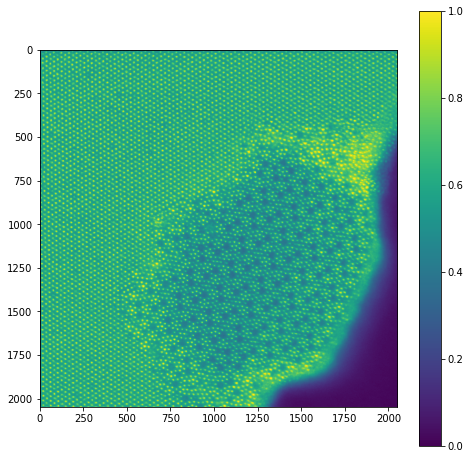

In [3]:
image = np.flipud(np.load('SuperImage.npy'))[:2048, :2048]

#normalize the image
image = (image - np.min(image)) / (np.max(image) - np.min(image))

fig, axes = plt.subplots(figsize = (8,8))
im1 = axes.imshow(image)
fig.colorbar(im1)

In [4]:
#First we start with a parameters dictionary that we pass to the SlidingFFT class
#The parameters are self-explanatory

parms_dict = {'interpolation_factor': 2, 'zoom_factor': 2, 'hamming_filter':True, 
              'window_size_x':256,
              'window_size_y':256, 'window_step_x':64, 'window_step_y':64}

#Instantiate the class
sliding_windows = SlidingFFT(parms_dict)

#Make the windows - do this by calling the MakeWindows method
windows = np.abs(sliding_windows.MakeWindows(image))

#Now finally, perform the FFTs on these windows
FFT_mats = sliding_windows.Do_Sliding_FFT(windows)


/content/fft_utils.py:49: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  full_slice = image[start_stop]


# Inspect the Windows

Here we plot a random selection of windows from the image

Text(0.5, 1.02, 'Random Selection of Windows')

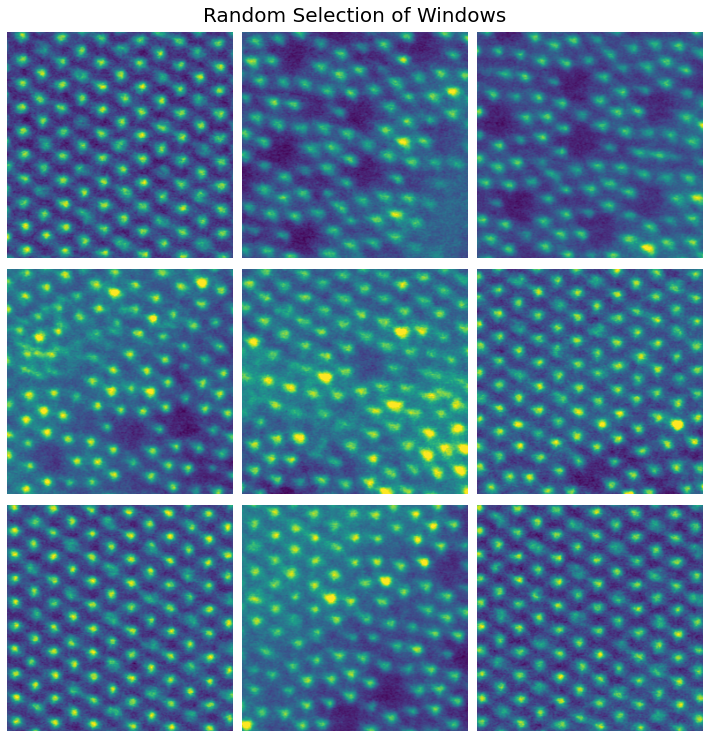

In [5]:
#Let's plot some windows and their respective FFTs

#Select 9 random images to plot
random_indices = np.random.choice(np.arange(windows.shape[0]), 9, replace = False)

fig, axes = plt.subplots(nrows=3, ncols=3, figsize = (10,10))
for ind, ax in enumerate(axes.flat):
  wind = windows[random_indices[ind], :,:]
  ax.imshow(wind)
  ax.axis('off')
fig.tight_layout()
fig.suptitle('Random Selection of Windows', y = 1.02, fontsize = 20)


Text(0.5, 1.02, '2D FFTs of Above Windows')

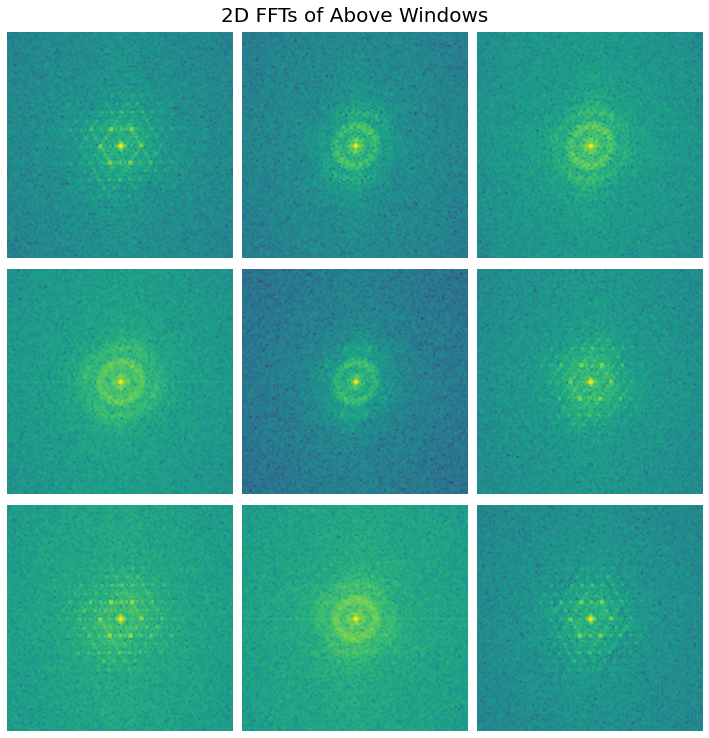

In [6]:
# We can also look at the FFTs in the same windows
fig, axes = plt.subplots(nrows=3, ncols=3, figsize = (10,10))
for ind, ax in enumerate(axes.flat):
  wind = FFT_mats[random_indices[ind], :,:]
  #Sometimes it helps to plot the log FFT for better visualization
  wind = np.log(np.abs(wind))
  ax.imshow(wind)
  ax.axis('off')
fig.tight_layout()
fig.suptitle('2D FFTs of Above Windows', y = 1.02, fontsize = 20)


# Spectral Unxmixing for Phase classification

Here we will take the data, reshape it to 2D and then perform NFINDR to recompute the FFTs from some number of 'pure' endmembers.


In [7]:
# Now let's do some NFINDR Unmixing

num_components = 3

#First we need to reshape the FFT matrices so it is 2D

FFT_mats = np.sqrt(np.abs(np.array(FFT_mats))) #This should help to accentuate the differences
FFT_mats[np.isnan(FFT_mats)]=0.0
FFT_mats[np.isinf(FFT_mats)]=0.0

#Remake it to 2D
FFT_mats_2D = FFT_mats.reshape(-1, FFT_mats.shape[1]*FFT_mats.shape[2])

#Pass it to the do_unmixing method
#There are three methods to choose from. 'nfindr', 'nmf', and 'pca'

endmembers, abundances, fig_handles = sliding_windows.do_unmixing(
                            FFT_mats = FFT_mats_2D, number_components=num_components,  
                                              method='nfindr')

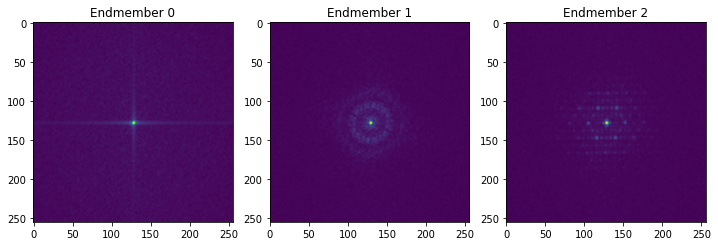

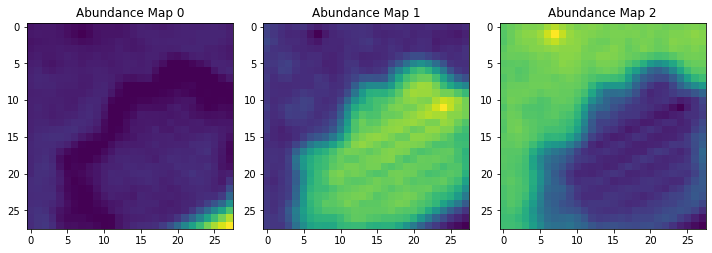

In [8]:
#Plot the results
endmembers_reshaped = endmembers.reshape(num_components, parms_dict['window_size_x'], 
                                         parms_dict['window_size_y'])

fig, axes = plt.subplots(nrows=1, ncols = num_components, figsize = (10,4))
for ind, ax in enumerate(axes.flat):
  axes[ind].imshow(endmembers_reshaped[ind,:,:])
  axes[ind].set_title('Endmember {}'.format(ind))
fig.tight_layout()

fig, axes = plt.subplots(nrows=1, ncols = num_components, figsize = (10,4))
for ind, ax in enumerate(axes.flat):
  axes[ind].imshow(abundances[:,:,ind])
  axes[ind].set_title('Abundance Map {}'.format(ind))
fig.tight_layout()

# Exercise

1. Test out the other modes decomposition above (PCA, NMF). How do they affect the results?
2. Play with the initial parms_dict to see how applying Hamming Filter and changing window size affects results. Warning: very small window sizes will lead to slow performance or possible memory issues!
2. Can you compute the reconstructed FFTs and plot the erorr spatially?